# Dependencies

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List, Tuple
from matplotlib import pyplot as pyplot
import matplotlib.pyplot as plt
import imageio

In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass

# Build Data Loading Functions

In [4]:
import gdown

In [5]:
url = 'https://drive.google.com/u/1/uc?id=1pV_hK8_tFfNQj95JoIHamvBesMWdpeoz'
output = 'data.zip'
gdown.download(url, output, quiet = False)

Downloading...
From (uriginal): https://drive.google.com/u/1/uc?id=1pV_hK8_tFfNQj95JoIHamvBesMWdpeoz
From (redirected): https://drive.google.com/uc?id=1pV_hK8_tFfNQj95JoIHamvBesMWdpeoz&confirm=t&uuid=e9a4b723-ce8e-46d8-bdeb-04f3e8a6b28d
To: D:\Desktop\projects\lip_reading\data.zip
100%|███████████████████████████████████████| 423M/423M [00:37<00:00, 11.2MB/s]


'data.zip'

In [6]:
gdown.extractall('data.zip')

['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [7]:
def load_video(path: str) -> List[float]:
    """
    Load a video file from the specified path, preprocess its frames, and return a list of standardized frames.

    Parameters:
    - path (str): The path to the video file to be loaded.

    Returns:
    - List[float]: A list of preprocessed frames as TensorFlow tensors. Each frame is standardized.
                   The frames are extracted from the original video, converted to grayscale, cropped,
                   and then standardized by subtracting the mean and dividing by the standard deviation.
    """
    # Open the video file for reading
    cap = cv2.VideoCapture(path)

    # Initialize a list to store the processed frames
    frames = []

    # Loop through all the frames in the video
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()

        # Convert the frame to grayscale
        frame = tf.image.rgb_to_grayscale(frame)

        # Crop the frame to the desired region of interest
        frames.append(frame[190:236, 80:220, :])

    # Release the video capture object
    cap.release()

    # Calculate the mean and standard deviation of the frames
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))

    # Standardize the frames by subtracting the mean and dividing by the standard deviation
    standardized_frames = tf.cast((frames - mean), tf.float32) / std

    return standardized_frames


In [8]:
vocab = [char for char in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [9]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token = "")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(), oov_token = "", invert = True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"size ={char_to_num.vocabulary_size()}"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] size =40


In [10]:
def load_alignments(path: str) -> List[str]:
    """
    Load alignment data from a text file at the specified path and return a list of phonetic tokens.

    Parameters:
    - path (str): The path to the text file containing alignment data.

    Returns:
    - List[str]: A list of phonetic tokens extracted from the alignment data.
    """
    # Open the file at the given path for reading
    with open(path, 'r') as f:
        lines = f.readlines()

    # Initialize a list to store the phonetic tokens
    tokens = []

    # Iterate over each line in the file
    for line in lines:
        # Split the line into tokens
        line = line.split()

        # Check if the third element is not 'sil' (silence)
        if line[2] != 'sil':
            # Add the token to the list
            tokens = [*tokens, ' ', line[2]]

    # Convert the list of tokens to a single string, excluding the first character
    # and use Unicode split for proper tokenization
    tokenized_string = char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

    return tokenized_string


In [11]:
def load_data(path: str):
    """
    Load video frames and corresponding alignments data for a given file path.

    Parameters:
    - path (str): The path to the video file to be loaded.

    Returns:
    - Tuple[List[tf.Tensor], List[str]]: A tuple containing two lists:
        - The first list contains preprocessed video frames as TensorFlow tensors.
        - The second list contains alignment data as strings.

    Note:
    - The function expects that the video file is located in the 'data/s1/' directory
      and follows the naming convention 'filename.mpg'.
    - The alignment file is expected to be in the 'data/alignments/s1/' directory
      and follows the naming convention 'filename.align'.
    """
    # Decode the input path from bytes to string
    path = bytes.decode(path.numpy())

    # Extract the file name from the path (Windows version)
    file_name = path.split('/')[-1].split('.')[0]

    # Create full paths for the video and alignment files
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')

    # Load video frames
    frames = load_video(video_path)

    # Load alignment data
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [12]:
test_path = './data/s1/bbal6n.mpg'

In [13]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [14]:
frames
# shape = (75, 46, 140, 1)
# Meaning:
# 75: n of frames in lenght (75 different images)
# 46: pixels high
# 140: pixels wide
# 1: one channel, because we've gone and converted that into RGB

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[ 1.4603739 ],
         [ 1.4603739 ],
         [ 1.4209043 ],
         ...,
         [ 0.15787826],
         [ 0.19734782],
         [ 0.07893913]],

        [[ 1.4603739 ],
         [ 1.4603739 ],
         [ 1.4209043 ],
         ...,
         [ 0.15787826],
         [ 0.07893913],
         [ 0.03946957]],

        [[ 1.4209043 ],
         [ 1.4209043 ],
         [ 1.3814348 ],
         ...,
         [ 0.07893913],
         [ 0.07893913],
         [ 0.07893913]],

        ...,

        [[ 0.94726956],
         [ 0.94726956],
         [ 0.94726956],
         ...,
         [ 9.94633   ],
         [ 9.867392  ],
         [ 9.867392  ]],

        [[ 0.94726956],
         [ 0.94726956],
         [ 0.94726956],
         ...,
         [ 9.90686   ],
         [ 9.867392  ],
         [ 9.867392  ]],

        [[ 0.94726956],
         [ 0.94726956],
         [ 0.94726956],
         ...,
         [ 9.90686   ],
         [ 9.86739

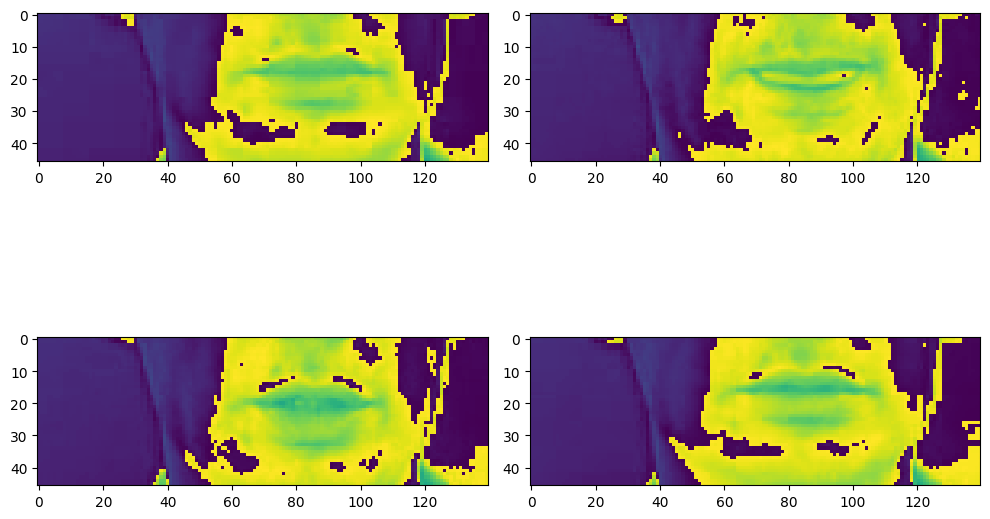

In [15]:
frames_plt = [frames[0], frames[10], frames[30], frames[60]]  # Replace with your actual frames

# Create a 2x2 grid of subplots
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
for i in range(4):
    plt.subplot(2, 2, i + 1)  # Create the i-th subplot in a 2x2 grid
    plt.imshow(frames_plt[i])     # Display the i-th frame

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()  # Show all the subplots in the same cell

# Substracting the mean and variance helps isolating the region, highlighted in yellow-green

In [16]:
alignments
# This is the numeric representation of what is being said

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [17]:
print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

['b', 'i', 'n', ' ', 'b', 'l', 'u', 'e', ' ', 'a', 't', ' ', 'l', ' ', 's', 'i', 'x', ' ', 'n', 'o', 'w']


In [18]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [19]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# Data Pipeline

In [20]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [21]:
frames, alignments = data.as_numpy_iterator().next()

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} FileNotFoundError: [Errno 2] No such file or directory: 'data\\alignments\\s1\\.align'
Traceback (most recent call last):

  File "D:\Desktop\projects\lip_reading\venv\lib\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    return func(device, token, args)

  File "D:\Desktop\projects\lip_reading\venv\lib\site-packages\tensorflow\python\ops\script_ops.py", line 147, in __call__
    outputs = self._call(device, args)

  File "D:\Desktop\projects\lip_reading\venv\lib\site-packages\tensorflow\python\ops\script_ops.py", line 154, in _call
    ret = self._func(*args)

  File "D:\Desktop\projects\lip_reading\venv\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\rhg22\AppData\Local\Temp\ipykernel_17144\3049874197.py", line 33, in load_data
    alignments = load_alignments(alignment_path)

  File "C:\Users\rhg22\AppData\Local\Temp\ipykernel_17144\3758649637.py", line 12, in load_alignments
    with open(path, 'r') as f:

  File "D:\Desktop\projects\lip_reading\venv\lib\site-packages\IPython\core\interactiveshell.py", line 286, in _modified_open
    return io_open(file, *args, **kwargs)

FileNotFoundError: [Errno 2] No such file or directory: 'data\\alignments\\s1\\.align'


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext]

In [ ]:
frames.shape # 2 sets of videos inside each batch

In [ ]:
test = data.as_numpy_iterator()

In [ ]:
val = test.next(); val[0]

In [ ]:
# fv = (val[0][1].astype(np.uint8) * 255).squeeze()
# imageio.mimsave('./animation.gif', fv, duration=100)


In [ ]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
# first 0: videos
# second 0: 1st video out of the batch
# third 0: return the first frame in the video
plt.imshow(val[0][0][0]) # we have 75 frames in each video

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

# Design the Deep Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
data.as_numpy_iterator().next()[0][0].shape

In [ ]:
"""
Neural Network Model for Video-Based Handwriting Recognition

This model is designed for recognizing handwriting in video sequences. It consists of convolutional layers for feature extraction, followed by Bidirectional LSTMs for sequence modeling, and a final dense layer for character classification.

Architecture:
- Convolutional Layers: These layers extract spatial features from input video frames.
- Bidirectional LSTMs: These layers model temporal dependencies in the video sequence.
- Dense Layer: This layer produces character predictions.

Parameters:
- Input Shape: (75, 46, 140, 1) - Input video frame dimensions.
- Conv3D Layers: Three convolutional layers with varying filter sizes and ReLU activations.
- MaxPool3D Layers: Max-pooling layers to downsample feature maps.
- TimeDistributed Layer: Flattens the feature maps.
- Bidirectional LSTMs: Two Bidirectional LSTM layers with dropout for sequence modeling.
- Dense Layer: Final output layer with softmax activation for character classification.

Note:
- The model is designed for character recognition tasks with a vocabulary size of (char_to_num.vocabulary_size() + 1).

Attributes:
    - model: A Keras Sequential model representing the neural network architecture.

Example Usage:
    model = Sequential()
    # Add layers as described above
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

"""

# Create a Sequential model, which is a linear stack of layers.
model = Sequential()

# Add a 3D convolutional layer with 128 filters, a 3x3x3 kernel, and input shape of (75, 46, 140, 1).
# Padding is used to maintain the same spatial dimensions.
model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'))
model.add(Activation('relu'))  # Apply ReLU activation function.
model.add(MaxPool3D((1, 2, 2)))  # Apply 3D max-pooling with a (1, 2, 2) pool size.

# Add another 3D convolutional layer with 256 filters and ReLU activation.
# Padding is 'same' to maintain dimensions.
model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

# Add another 3D convolutional layer with 75 filters and ReLU activation.
# Padding is 'same' to maintain dimensions.
model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

# TimeDistributed layer is used to apply Flatten to each time step separately.
model.add(TimeDistributed(Flatten()))

# Add a Bidirectional LSTM layer with 128 units and 'Orthogonal' kernel initialization.
# Return sequences to get outputs at each time step.
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))  # Apply dropout for regularization.

# Add another Bidirectional LSTM layer with 128 units and 'Orthogonal' kernel initialization.
# Return sequences to get outputs at each time step.
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))  # Apply dropout for regularization.

# Add a Dense layer with output size equal to the vocabulary size plus one.
# Use 'he_normal' kernel initialization and softmax activation.
model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))


``a``

In [ ]:
model.summary()

In [ ]:
yhat = model.predict(val[0])

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]])

In [ ]:
yhat[0].shape
# we are getting 75 outputs, each one one of these represented as an array with 41 values, which is
# a one-hot encoding of our vocabulary

In [ ]:
tf.argmax(yhat[0], axis=1) # this is returning back what our model is actually predicting

# Setup Training Options and Train

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('model','checkpoint'), monitor='loss', save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(test)

# Make Predictions

In [ ]:
# model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

In [ ]:
url = 'https://drive.google.com/u/1/uc?id=1HzJYaEntb1-jddsZ-254eGj9uTlrqx5v'
output = 'checkpoints.zip'
gdown.download(url, output, quiet = False)

In [ ]:
gdown.extractall('checkpoints.zip', 'models')

In [ ]:
model.load_weights('models/checkpoint')

In [ ]:
# test_data = test.as_numpy_iterrator()

In [ ]:
test.next()

In [ ]:
sample = test.next()

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]